# Modeling

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import pandas as pd
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from faa_p2.config import CLEAN_DATA_FILE, MODELS, KEYS, MODEL_RESULTS_FILE, RANDOM_STATE, DATA_SPLIT_RATIO, LR
warnings.filterwarnings("ignore")


## Load data

In [2]:
# Housing dataset
df = pd.read_csv(CLEAN_DATA_FILE, index_col=0)
y = df["medv"]
x = df.drop(columns=["medv"], axis=1)

# Model performance dataset
model_perf = pd.read_csv(MODEL_RESULTS_FILE).set_index("model")

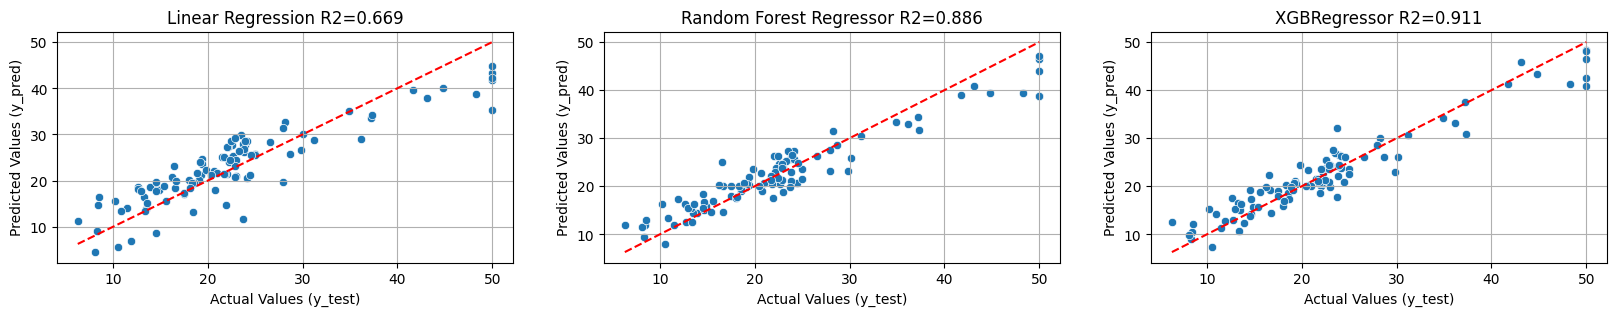

In [3]:
result = []

fig, axes = plt.subplots(ncols=len(MODELS), figsize=(20, 3))
axes = axes.flatten()

for key, ax in zip(KEYS, axes):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=DATA_SPLIT_RATIO, random_state=RANDOM_STATE
    )
    model = joblib.load(MODELS[key]["filename"])
    model_metrics = model_perf.loc[MODELS[key]["name"]]

    if key == LR:
        scaler = StandardScaler().fit(x_train)
        x_test = scaler.transform(x_test)
        x_train = scaler.transform(x_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)

    sns.scatterplot(x=y_test, y=y_pred, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    ax.set_xlabel("Actual Values (y_test)")
    ax.set_ylabel("Predicted Values (y_pred)")
    ax.set_title(f'{MODELS[key]["name"]} R2={model_metrics["test_r2"]:.3f}')
    ax.grid(True)
plt.show()

Native feature importance info

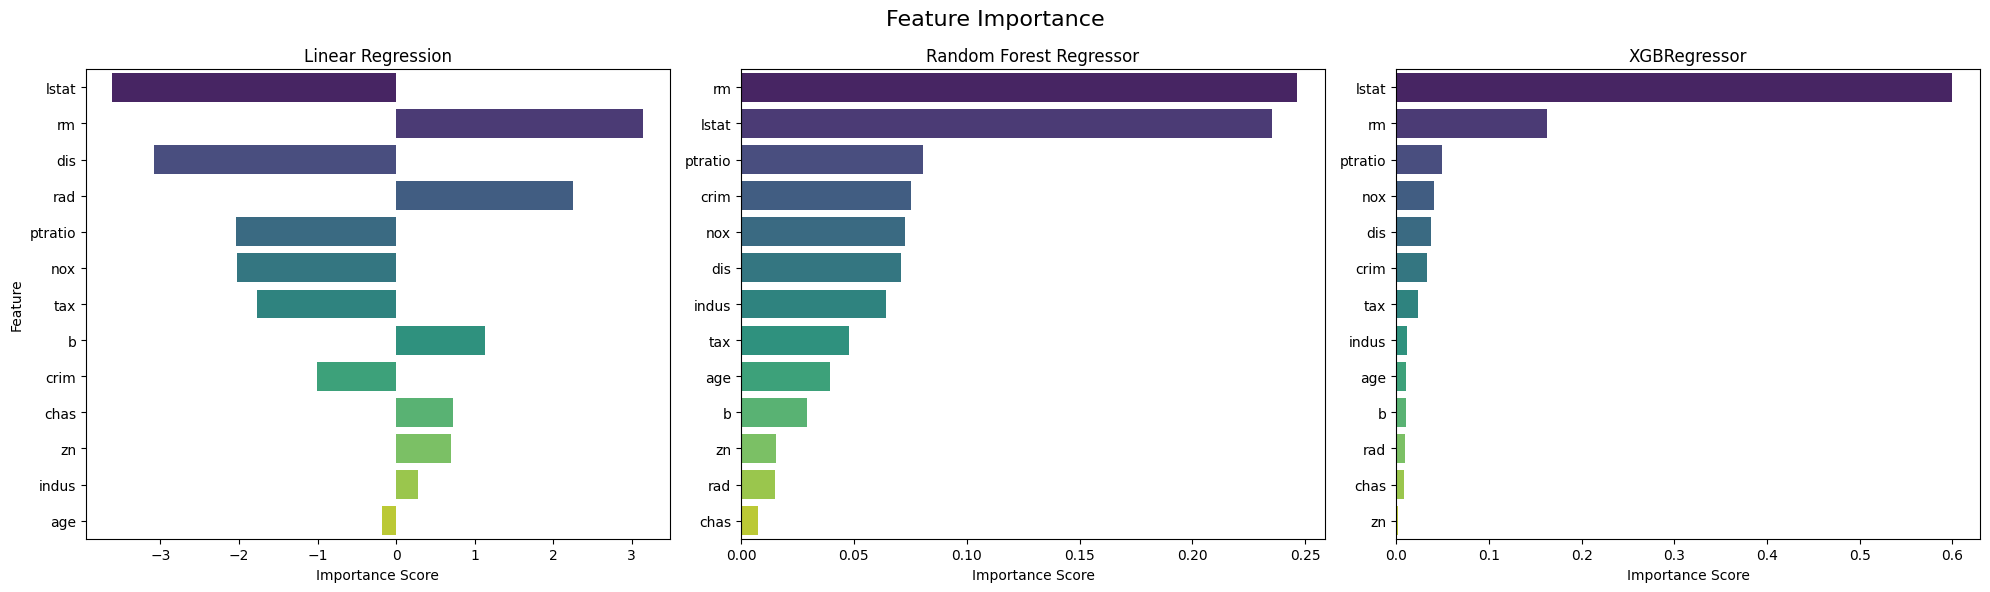

In [4]:
feature_names = x_train.columns.tolist()

fig, axes = plt.subplots(
    ncols=len(MODELS),
    figsize=(20, 6),
)

if len(MODELS) > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for key, ax in zip(KEYS, axes):
    model = joblib.load(MODELS[key]["filename"])

    if key == "lr":
        importances = model.coef_
        if importances.ndim > 1:
            importances = importances.flatten()
    else:
        # Random Forest and XGBoost
        importances = model.feature_importances_

    df_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})

    df_imp["Abs_Importance"] = df_imp["Importance"].abs()
    df_imp = df_imp.sort_values(by="Abs_Importance", ascending=False)

    sns.barplot(data=df_imp, x="Importance", y="Feature", ax=ax, palette="viridis")

    ax.set_title(f"{MODELS[key]['name']}")
    ax.set_xlabel("Importance Score")

    if ax != axes[0]:
        ax.set_ylabel("")

fig.suptitle("Feature Importance", fontsize=16)
plt.tight_layout()
plt.show()
